## NSMC 정제하기

* 감성분석을 위해, Naver Movie Corpus (https://github.com/e9t/nsmc/) 사용

* 영화 100개에 대한 리뷰. train 15만, test 5만, 총 20만개.
* 긍정(1) : 점수 9 ~ 10점
* 부정(0) : 점수 1 ~ 4점

In [1]:
import json
import os
import re
from pprint import pprint

from konlpy.tag import Okt
okt = Okt()

# from konlpy.tag import Mecab
# mecab = Mecab()

import MeCab
mecab = MeCab.Tagger()

In [2]:
def read_documents(filename):
    with open(filename, encoding='utf-8') as f:
        documents = [line.split('\t') for line in f.read().splitlines()]
        documents = documents[1:]
        
    return documents
    
train_docs = read_documents("data/nsmc/ratings_train.txt")
test_docs = read_documents("data/nsmc/ratings_test.txt")

In [3]:
print(len(train_docs))
print(len(test_docs))

150000
50000


In [4]:
train_docs[100]   # id, review, label

['10044377', '신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.', '1']

### 함수 정의.

In [5]:
# 리뷰 분석에서는 영문이나 특수문자도 의미를 가질 수 있기 때문에 cleaning을 먼저 하지 않고
# 먼저 전체 단어를 먼저 확인 후 cleaning은 나중에 처리한다.

def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    return doc

def define_stopwords(path):
    SW = set()
    
    with open(path, encoding='utf-8') as f:
        for word in f:
            SW.add(word)
            
    return SW

def mecab_morphs(text):
    morphs = []

    pattern = re.compile(".*\t[A-Z]+")
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    temp = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
    for token in temp:
        morphs.append(token[0])

    return morphs

def text_tokenizing(doc):
    return [word for word in mecab_morphs(doc) if word not in SW and len(word) > 1]
    
    # wordcloud를 위해 명사만 추출하는 경우.
    #return [word for word in mecab.nouns(doc) if word not in SW and len(word) > 1]

### tokeninzing

In [6]:
SW = define_stopwords("stopwords-ko.txt")

# toknized 결과를 파일에 저장

if os.path.exists('data/train_docs.json'):
    with open("data/train_docs.json", encoding='utf-8') as f:
        train_data = json.load(f)
else:
    train_data = [(text_tokenizing(line[1]), line[2]) for line in train_docs if text_tokenizing(line[1])]

#     train_data = []
#     for line in train_docs:
#         if text_tokenizing(line[1]):
#             train_data.append((text_tokenzing(line[1]), line[2]))
    
    with open("data/train_docs.json", 'w', encoding='utf-8') as f:
        json.dump(train_data, f, ensure_ascii=False, indent='\t')
        
if os.path.exists('data/test_docs.json'):
    with open("data/test_docs.json", encoding='utf-8') as f:
        test_data = json.load(f)
else:
    test_data = [(text_tokenizing(line[1]), line[2]) for line in test_docs if text_tokenizing(line[1])]
    
    with open("data/test_docs.json", 'w', encoding='utf-8') as f:
        json.dump(test_data, f, ensure_ascii=False, indent='\t')

pprint(train_data[100])
pprint(test_data[100])

[['재미없', '진심', '캐스팅', '못한'], '0']
[['ost', '..', '정말', '어요', '영화', '자체', '의문', '지만', 'ㅎㅎ'], '1']


### NLTK를 이용한 histogram 분석.

* 데이터 분석을 하기 위해 기본적인 정보들을 확인.

* nltk 라이브러리를 이용하여 전처리.

In [7]:
import nltk

total_tokens = [token for doc in train_data for token in doc[0]]
print(len(total_tokens))

1206841


In [8]:
text = nltk.Text(total_tokens, name='NMSC')
print(len(set(text.tokens)))  # 중복 제거

pprint(text.vocab().most_common(10))

51722
[('영화', 57614),
 ('..', 22813),
 ('는데', 11543),
 ('너무', 11002),
 ('정말', 9783),
 ('으로', 9322),
 ('네요', 9053),
 ('재밌', 9022),
 ('지만', 8366),
 ('진짜', 8326)]


### Histogram 그리기.

In [9]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

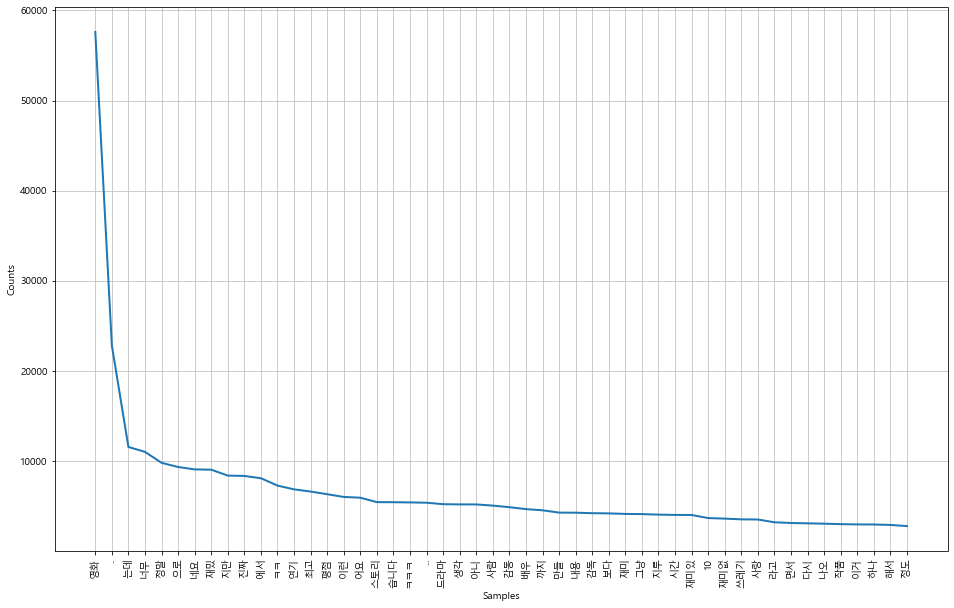

In [10]:
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

plt.figure(figsize=(16, 10))
text.plot(50)

### WordCloud 그리기.

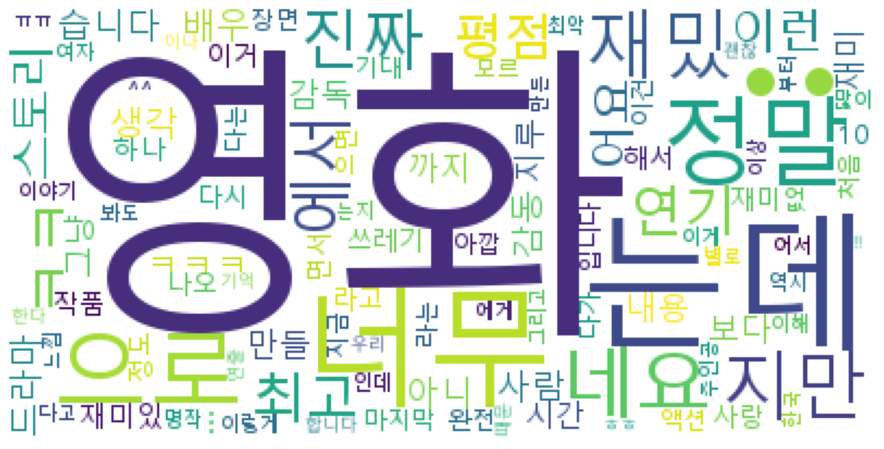

In [11]:
from wordcloud import WordCloud

# wordcloud는 형태소분석 데이터보다는 명사분석 데이터를 사용하는 것이 좋다.

data = text.vocab().most_common(100)

wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                      relative_scaling = 0.2,
                      #stopwords=STOPWORDS,
                      background_color='white',
                      ).generate_from_frequencies(dict(data))

plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()